In [3]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import skew
from scipy.stats import chisquare
from scipy.stats import kruskal
import scikit_posthocs
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import xgboost as xgb
from xgboost import XGBClassifier

In [4]:
df = pd.read_excel(r"C:\Users\rayde\Desktop\DSI_kickstarterscrape_dataset.xlsx", parse_dates=['funded date'])

C:\Users\rayde\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Your version of xlrd is 1.2.0. In xlrd >= 2.0, only the xls format is supported. As a result, the openpyxl engine will be used if it is installed and the engine argument is not specified. Install openpyxl instead.
  """Entry point for launching an IPython kernel.


In [5]:
df.columns

Index(['project id', 'name', 'url', 'category', 'subcategory', 'location',
       'status', 'goal', 'pledged', 'funded percentage', 'backers',
       'funded date', 'levels', 'reward levels', 'updates', 'comments',
       'duration'],
      dtype='object')

In [6]:
df.describe()

,project id,goal,pledged,funded percentage,backers,levels,updates,comments,duration
count,4.595700e+04,4.595700e+04,4.594500e+04,45957.000000,45957.000000,45957.000000,45957.00000,45957.000000,45957.000000
mean,1.080800e+09,1.194271e+04,4.980750e+03,1.850129,69.973192,8.004939,4.08508,8.379529,39.995547
std,6.218057e+08,1.887583e+05,5.674162e+04,88.492706,688.628479,4.233907,6.43922,174.015737,17.414458
min,3.940900e+04,1.000000e-02,0.000000e+00,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000
25%,5.438962e+08,1.800000e+03,1.960000e+02,0.044000,5.000000,5.000000,0.00000,0.000000,30.000000
50%,1.078345e+09,4.000000e+03,1.310000e+03,1.000000,23.000000,7.000000,2.00000,0.000000,32.000000
75%,1.621596e+09,9.862000e+03,4.165000e+03,1.115640,59.000000,10.000000,6.00000,3.000000,48.390000
max,2.147460e+09,2.147484e+07,1.026684e+07,15066.000000,87142.000000,80.000000,149.00000,19311.000000,91.960000


## Browse Duplicates

In [7]:
bool_filter = df['project id'].duplicated() == True
values = list(df['project id'][bool_filter].values)
df[df['project id'].isin(values)].sort_values('project id')

,project id,name,url,category,subcategory,location,status,goal,pledged,funded percentage,backers,funded date,levels,reward levels,updates,comments,duration
45651,2140333236,Imagined Family Heirlooms: An Archive of Inher...,http://www.kickstarter.com/projects/andersonst...,Photography,Photography,"Little Rock, AR",successful,5800.0,8521.0,1.469138,110,2011-07-29 00:53:53+00:00,16,"$10,$20,$35,$50,$75,$100,$150,$200,$225,$300,$...",5,4,67.00
45652,2140333236,Imagined Family Heirlooms: An Archive of Inher...,http://www.kickstarter.com/projects/andersonst...,Photography,Photography,"Little Rock, AR",successful,5800.0,8521.0,1.469138,110,2011-07-29 00:53:53+00:00,16,"$10,$20,$35,$50,$75,$100,$150,$200,$225,$300,$...",5,4,67.00
45653,2140344109,Help Fund Thana Alexa's Debut Album &quot;Ode ...,http://www.kickstarter.com/projects/1024906052...,Music,Jazz,"New York, NY",successful,15000.0,16678.0,1.111867,142,2012-05-20 20:36:57+00:00,16,"$1,$5,$10,$15,$25,$50,$75,$100,$200,$250,$300,...",5,2,32.00
45654,2140344109,Help Fund Thana Alexa's Debut Album &quot;Ode ...,http://www.kickstarter.com/projects/1024906052...,Music,Jazz,"New York, NY",successful,15000.0,16678.0,1.111867,142,2012-05-20 20:36:57+00:00,16,"$1,$5,$10,$15,$25,$50,$75,$100,$200,$250,$300,...",5,2,32.00
45655,2140513451,The Cookie Chew - Changing the Way We Eat a Co...,http://www.kickstarter.com/projects/1650956569...,Food,Food,"San Diego, CA",successful,4500.0,5540.0,1.231111,89,2010-08-24 04:43:00+00:00,5,"$10,$50,$75,$100,$500",14,17,43.27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45930,2146435917,Making Mama(s) Proud: The 2011 &quot;Donna/Mad...,http://www.kickstarter.com/projects/johnpaulka...,Theater,Theater,"Los Angeles, CA",successful,5000.0,5390.0,1.078000,86,2011-06-04 08:56:58+00:00,8,"$1,$10,$25,$50,$100,$200,$500,$1,000",5,1,30.00
45931,2146437406,The Production of Erasure,http://www.kickstarter.com/projects/295025953/...,Photography,Photography,"Brooklyn, NY",successful,1200.0,1220.0,1.016667,17,2011-03-03 04:09:38+00:00,6,"$15,$25,$50,$100,$200,$500",1,0,30.00
45932,2146437406,The Production of Erasure,http://www.kickstarter.com/projects/295025953/...,Photography,Photography,"Brooklyn, NY",successful,1200.0,1220.0,1.016667,17,2011-03-03 04:09:38+00:00,6,"$15,$25,$50,$100,$200,$500",1,0,30.00
45933,2146534146,CALLING on ANGELS - not FOR KIDS ONLY!,http://www.kickstarter.com/projects/callingona...,Film &amp; Video,Film &amp; Video,"Burbank, CA",failed,10000.0,250.0,0.025000,1,2011-09-10 19:00:47+00:00,11,"$10,$25,$50,$75,$100,$150,$250,$500,$1,000,$1,...",0,0,60.00


In [8]:
df[df['project id'].duplicated(keep=False)].sort_values(by='project id').head()

,project id,name,url,category,subcategory,location,status,goal,pledged,funded percentage,backers,funded date,levels,reward levels,updates,comments,duration
45651,2140333236,Imagined Family Heirlooms: An Archive of Inher...,http://www.kickstarter.com/projects/andersonst...,Photography,Photography,"Little Rock, AR",successful,5800.0,8521.0,1.469138,110,2011-07-29 00:53:53+00:00,16,"$10,$20,$35,$50,$75,$100,$150,$200,$225,$300,$...",5,4,67.00
45652,2140333236,Imagined Family Heirlooms: An Archive of Inher...,http://www.kickstarter.com/projects/andersonst...,Photography,Photography,"Little Rock, AR",successful,5800.0,8521.0,1.469138,110,2011-07-29 00:53:53+00:00,16,"$10,$20,$35,$50,$75,$100,$150,$200,$225,$300,$...",5,4,67.00
45653,2140344109,Help Fund Thana Alexa's Debut Album &quot;Ode ...,http://www.kickstarter.com/projects/1024906052...,Music,Jazz,"New York, NY",successful,15000.0,16678.0,1.111867,142,2012-05-20 20:36:57+00:00,16,"$1,$5,$10,$15,$25,$50,$75,$100,$200,$250,$300,...",5,2,32.00
45654,2140344109,Help Fund Thana Alexa's Debut Album &quot;Ode ...,http://www.kickstarter.com/projects/1024906052...,Music,Jazz,"New York, NY",successful,15000.0,16678.0,1.111867,142,2012-05-20 20:36:57+00:00,16,"$1,$5,$10,$15,$25,$50,$75,$100,$200,$250,$300,...",5,2,32.00
45655,2140513451,The Cookie Chew - Changing the Way We Eat a Co...,http://www.kickstarter.com/projects/1650956569...,Food,Food,"San Diego, CA",successful,4500.0,5540.0,1.231111,89,2010-08-24 04:43:00+00:00,5,"$10,$50,$75,$100,$500",14,17,43.27


## Drop Duplicates on Project Id / Drop Cancelled or Live Projects

In [9]:
new_df = df.drop_duplicates(subset=['project id'])
new_df = new_df.query('status == "successful" | status =="failed"')

In [10]:
new_df['status'].unique()

array(['successful', 'failed'], dtype=object)

## Fix inconsistent data entry / importation errors

In [11]:
new_df.subcategory.unique()

array(['Short Film', 'Board & Card Games', 'Documentary', 'Fashion',
       'Music', 'Illustration', 'Open Software', 'Indie Rock', 'Dance',
       'Fiction', 'Nonfiction', 'Film &amp; Video', 'Theater', 'Games',
       'Art Book', 'Animation', 'Country & Folk', 'Comics', 'Webseries',
       'Technology', 'Performance Art', 'Narrative Film', 'Video Games',
       'Product Design', 'Painting', 'Photography', 'Conceptual Art',
       'Rock', 'Jazz', 'Classical Music', 'Food', 'Art', 'Pop',
       'Journalism', 'Poetry', 'World Music', 'Sculpture', 'Publishing',
       'Electronic Music', "Children's Book", 'Open Hardware',
       'Graphic Design', 'Hip-Hop', 'Public Art', 'Mixed Media',
       'Periodical', 'Crafts', 'Design', 'Digital Art',
       'Board &amp; Card Games', 'Country &amp; Folk'], dtype=object)

In [12]:
new_df.category.unique()

array(['Film & Video', 'Games', 'Fashion', 'Music', 'Art', 'Technology',
       'Dance', 'Publishing', 'Theater', 'Comics', 'Design',
       'Photography', 'Food', 'Film &amp; Video'], dtype=object)

In [13]:
new_df = new_df.replace(to_replace="Film &amp; Video", value="Film & Video")
new_df = new_df.replace(to_replace='Board &amp; Card Games', value="Board & Card Games")
new_df = new_df.replace(to_replace='Country &amp; Folk', value="Country & Folk")

In [14]:
new_df.subcategory.unique()

array(['Short Film', 'Board & Card Games', 'Documentary', 'Fashion',
       'Music', 'Illustration', 'Open Software', 'Indie Rock', 'Dance',
       'Fiction', 'Nonfiction', 'Film & Video', 'Theater', 'Games',
       'Art Book', 'Animation', 'Country & Folk', 'Comics', 'Webseries',
       'Technology', 'Performance Art', 'Narrative Film', 'Video Games',
       'Product Design', 'Painting', 'Photography', 'Conceptual Art',
       'Rock', 'Jazz', 'Classical Music', 'Food', 'Art', 'Pop',
       'Journalism', 'Poetry', 'World Music', 'Sculpture', 'Publishing',
       'Electronic Music', "Children's Book", 'Open Hardware',
       'Graphic Design', 'Hip-Hop', 'Public Art', 'Mixed Media',
       'Periodical', 'Crafts', 'Design', 'Digital Art'], dtype=object)

In [15]:
new_df.category.unique()

array(['Film & Video', 'Games', 'Fashion', 'Music', 'Art', 'Technology',
       'Dance', 'Publishing', 'Theater', 'Comics', 'Design',
       'Photography', 'Food'], dtype=object)

In [16]:
new_df['name'] = new_df.name.str.replace("&quot;", '"')

In [17]:
new_df.name.iloc[4]

'Dinner Party - a short film about friendship... and revenge'

# Identify outliers in potential outcome variables

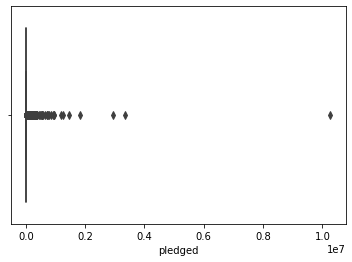

In [18]:
sns.boxplot(x=df['pledged'])

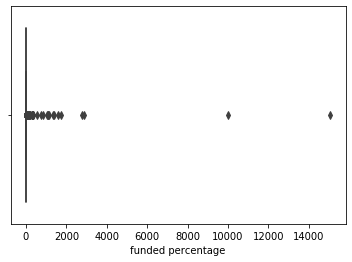

In [19]:
sns.boxplot(x=df['funded percentage'])

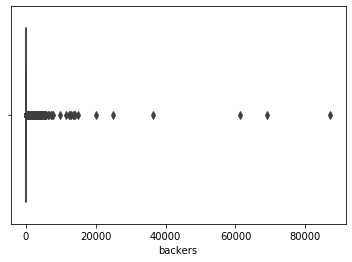

In [20]:
sns.boxplot(x=df['backers'])

In [21]:
df['pledged'].sort_values(ascending=False)

10710    10266845.0
41151     3336372.0
42674     2933252.0
11231     1836447.0
35458     1464706.0
            ...    
34274           NaN
35032           NaN
40759           NaN
40872           NaN
44132           NaN
Name: pledged, Length: 45957, dtype: float64

In [22]:
drop_columns = df['pledged'].sort_values(ascending=False).head(3).index
df.drop(drop_columns, axis=0, inplace=True)
df['pledged'].sort_values(ascending=False)

11231    1836447.0
35458    1464706.0
4086     1254120.0
17468    1192793.0
4114      942578.0
           ...    
34274          NaN
35032          NaN
40759          NaN
40872          NaN
44132          NaN
Name: pledged, Length: 45954, dtype: float64

In [23]:
for each in ['funded percentage','backers']:
    df[f'z_{each}'] = np.abs(stats.zscore(df[each]))

In [24]:
drop_columns = df[df['z_funded percentage']> 3].sort_values('z_funded percentage', ascending=False).index
df.drop(drop_columns, axis=0, inplace=True)

,project id,name,url,category,subcategory,location,status,goal,pledged,funded percentage,backers,funded date,levels,reward levels,updates,comments,duration,z_funded percentage,z_backers
29868,1404938334,THE SKY HAS FALLEN - All Practical FX Horror Film,http://www.kickstarter.com/projects/37572539/t...,Film &amp; Video,Narrative Film,"Springfield, MO",successful,1.0,2867.0,2866.5,41,2012-03-23 06:02:15+00:00,13,"$1,$5,$10,$20,$30,$50,$100,$150,$200,$500,$1,0...",7,2,29.96,32.371375,0.068724
33072,1555376536,THE SKY HAS FALLEN - Independent Horror Film,http://www.kickstarter.com/projects/37572539/t...,Film &amp; Video,Narrative Film,"Springfield, MO",successful,1.0,2795.0,2795.0,24,2011-08-20 11:48:18+00:00,11,"$1,$10,$15,$30,$50,$100,$150,$500,$1,000,$1,50...",13,0,70.00,31.563405,0.116906


In [26]:
drop_columns = df[df['z_backers']> 3].sort_values('z_backers', ascending=False).head(3).index
df.drop(drop_columns, axis=0, inplace=True)
df[df['z_backers']> 3].sort_values('z_backers', ascending=False).head(3)

,project id,name,url,category,subcategory,location,status,goal,pledged,funded percentage,backers,funded date,levels,reward levels,updates,comments,duration,z_funded percentage,z_backers
4114,195314440,TikTok+LunaTik Multi-Touch Watch Kits,http://www.kickstarter.com/projects/1104350651...,Design,Product Design,"Chicago, IL",successful,15000.0,942578.0,62.838562,13512,2010-12-17 04:02:14+00:00,6,"$1,$25,$50,$70,$150,$500",47,4187,30.0,0.689213,38.111243
3800,179140598,Carmageddon: Reincarnation,http://www.kickstarter.com/projects/stainlessg...,Games,Video Games,"Isle Of Wight, United Kingdom",live,400000.0,498954.0,1.247384,13020,2012-06-07 03:00:00+00:00,24,"$1,$15,$15,$25,$25,$30,$45,$50,$75,$100,$100,$...",18,4125,29.5,0.006784,36.716800
35458,1668263241,Elevation Dock: The Best Dock For iPhone,http://www.kickstarter.com/projects/hop/elevat...,Design,Product Design,"Portland, OR",successful,75000.0,1464706.0,19.529425,12521,2012-02-11 20:01:11+00:00,10,"$59,$79,$85,$118,$150,$250,$500,$2,000,$5,000,...",15,694,60.0,0.199808,35.302517


## Create new features out of funded date and location

In [27]:
new_df['duration_td'] = new_df.duration.apply(lambda x: datetime.timedelta(days=x))
new_df[['duration','duration_td']].dtypes

duration               float64
duration_td    timedelta64[ns]
dtype: object

In [28]:
new_df['Posting_Date'] = new_df['funded date'] - new_df['duration_td']
new_df[['Posting_Date','duration','duration_td', 'funded date']].head()

,Posting_Date,duration,duration_td,funded date
0,2011-07-20 19:28:17+00:00,30.00,30 days 00:00:00,2011-08-19 19:28:17+00:00
1,2010-06-15 23:39:48+00:00,47.18,47 days 04:19:12,2010-08-02 03:59:00+00:00
3,2012-03-06 20:57:12+00:00,32.22,32 days 05:16:48,2012-04-08 02:14:00+00:00
4,2011-05-02 15:25:39+00:00,30.00,30 days 00:00:00,2011-06-01 15:25:39+00:00
5,2011-06-01 03:13:48+00:00,21.43,21 days 10:19:12,2011-06-22 13:33:00+00:00


In [29]:
new_df['year_funded'] = new_df['funded date'].dt.year
new_df['month_funded'] = new_df['funded date'].dt.month
new_df['day_funded'] = new_df['funded date'].dt.day
new_df['time_funded'] = new_df['funded date'].dt.time
new_df['dayOfWeek_funded'] = new_df['funded date'].dt.dayofweek
new_df[['year_funded','month_funded', 'day_funded', 'time_funded', 'dayOfWeek_funded']]

,year_funded,month_funded,day_funded,time_funded,dayOfWeek_funded
0,2011,8,19,19:28:17,4
1,2010,8,2,03:59:00,0
3,2012,4,8,02:14:00,6
4,2011,6,1,15:25:39,2
5,2011,6,22,13:33:00,2
...,...,...,...,...,...
45952,2012,3,30,13:57:00,4
45953,2012,4,22,02:12:10,6
45954,2012,1,16,05:00:00,0
45955,2012,5,19,19:44:47,5


In [30]:
new_df['year_posted'] = new_df['Posting_Date'].dt.year
new_df['month_posted'] = new_df['Posting_Date'].dt.month
new_df['day_posted'] = new_df['Posting_Date'].dt.day
new_df['time_posted'] = new_df['Posting_Date'].dt.time
new_df['dayOfWeek_posted'] = new_df['Posting_Date'].dt.dayofweek
new_df[['year_posted','month_posted', 'day_posted', 'time_posted', 'dayOfWeek_posted']]

,year_posted,month_posted,day_posted,time_posted,dayOfWeek_posted
0,2011,7,20,19:28:17,2
1,2010,6,15,23:39:48,1
3,2012,3,6,20:57:12,1
4,2011,5,2,15:25:39,0
5,2011,6,1,03:13:48,2
...,...,...,...,...,...
45952,2012,2,21,18:01:48,1
45953,2012,2,22,03:09:46,2
45954,2011,12,19,21:19:12,0
45955,2012,4,19,19:44:47,3


In [31]:
new_df['city'], new_df['state'] = new_df['location'].str.split(', ', 1).str
new_df[['city', 'state', 'location']]

C:\Users\rayde\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  """Entry point for launching an IPython kernel.


,city,state,location
0,Columbia,MO,"Columbia, MO"
1,Maplewood,NJ,"Maplewood, NJ"
3,Los Angeles,CA,"Los Angeles, CA"
4,Novi,MI,"Novi, MI"
5,Portland,OR,"Portland, OR"
...,...,...,...
45952,Austin,TX,"Austin, TX"
45953,Los Angeles,CA,"Los Angeles, CA"
45954,Los Angeles,CA,"Los Angeles, CA"
45955,Vero Beach,FL,"Vero Beach, FL"


In [32]:
new_df['city'].unique()

array(['Columbia', 'Maplewood', 'Los Angeles', ..., 'Peaks',
       'Lumberville', 'Lake Oswego'], dtype=object)

In [33]:
new_df['state'].unique()

array(['MO', 'NJ', 'CA', 'MI', 'OR', 'TN', 'IL', nan, 'NY', 'DC', 'ID',
       'FL', 'TX', 'CO', 'ME', 'Taiwan', 'IN', 'Norway', 'MN', 'NC', 'MA',
       'PA', 'CT', 'Chile', 'MD', 'HI', 'VA', 'WA', 'AZ', 'OH', 'NV',
       'Haiti', 'GA', 'AL', 'UT', 'Canada', 'LA', 'SC', 'Ecuador', 'WI',
       'Jamaica', 'Argentina', 'Hong Kong', 'Germany', 'NM', 'NE',
       'Guatemala', 'IA', 'WY', 'Australia', 'RI', 'Sweden', 'OK', 'DE',
       'South Africa', 'AK', 'WV', 'Nepal', 'MT', 'KY', 'VT', 'Kenya',
       'Bosnia and Herzegovina', 'Iceland', 'Mexico', 'KS', 'Hungary',
       'Indonesia', 'China', 'SD', 'Cuba', 'Peru', 'Italy', 'Netherlands',
       'Singapore', 'Ethiopia', 'NH', 'New Zealand', 'France',
       'United Kingdom', 'Austria', 'Turkey', 'AR', 'Mt', 'Congo',
       'Colombia', 'India', 'Mongolia', 'MS', 'Israel', 'Dominica',
       'Finland', 'Czech Republic', 'Japan', 'Virgin Islands, U.S.',
       'Lebanon', 'Armenia', 'Portugal', 'Qatar', 'Morocco', 'Martinique',
       'Pue

In [34]:
new_df = new_df.replace(to_replace='Virginia', value="VA")

In [35]:
x, y = new_df[new_df.state == 'Middleburg, MD']['state'].str.split(', ', 1).str
row_val = list(new_df[new_df.state == 'Middleburg, MD'].index)[0]

new_df.loc[[row_val],['city']] = x
new_df.loc[[row_val], ['state']]= y
new_df.loc[row_val]

C:\Users\rayde\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  """Entry point for launching an IPython kernel.


project id                                                  1637912974
name                                                        Light Ball
url                  http://www.kickstarter.com/projects/819627388/...
category                                                    Technology
subcategory                                                 Technology
location                                            10, Middleburg, MD
status                                                          failed
goal                                                           19500.0
pledged                                                          103.0
funded percentage                                             0.005282
backers                                                              3
funded date                                  2012-03-31 03:59:00+00:00
levels                                                               6
reward levels                         $25,$100,$200,$750,$2,000,$3,500
update

In [36]:
new_df['country'] = new_df['state'].replace(to_replace=r'^..{1}$', value="USA", regex=True)
new_df[new_df.country != 'USA'].head()

,project id,name,url,category,subcategory,location,status,goal,pledged,funded percentage,...,time_funded,dayOfWeek_funded,year_posted,month_posted,day_posted,time_posted,dayOfWeek_posted,city,state,country
11,727286,Offline Wikipedia iPhone app,http://www.kickstarter.com/projects/dphiffer/o...,Technology,Open Software,NaN,successful,99.0,145.0,1.464646,...,06:59:59,1,2009,4,25,15:38:23,5,NaN,NaN,NaN
14,893085,Esperanza Farm: A Novel,http://www.kickstarter.com/projects/JesusMaria...,Publishing,Fiction,NaN,failed,6500.0,765.0,0.117692,...,03:59:00,4,2010,5,16,19:49:24,6,NaN,NaN,NaN
29,1512678,Eyes and Ears on English - comedy/English educ...,http://www.kickstarter.com/projects/1787808582...,Film & Video,Film & Video,"Taipei, Taiwan",failed,12000.0,1502.0,0.125167,...,05:15:04,6,2011,4,7,05:15:04,3,Taipei,Taiwan,Taiwan
42,2117470,""" Hugo's There "" - Real News. Unbelievably.",http://www.kickstarter.com/projects/mastermind...,Film & Video,Webseries,"Oslo, Norway",failed,8400.0,25.0,0.002976,...,01:20:25,0,2011,7,25,01:20:25,0,Oslo,Norway,Norway
49,2442649,Dream with Me--A documentary about one year in...,http://www.kickstarter.com/projects/1800556280...,Film & Video,Documentary,NaN,successful,5000.0,5615.0,1.123000,...,01:08:00,4,2009,9,15,03:46:24,1,NaN,NaN,NaN


In [37]:
series_1 = new_df[new_df.country != 'USA']['state'].apply(lambda x: np.nan)
indices= list(new_df[new_df.country != 'USA'].index)
new_df.loc[indices, ['state']] = series_1

In [38]:
new_df['state'].unique()

array(['MO', 'NJ', 'CA', 'MI', 'OR', 'TN', 'IL', nan, 'NY', 'DC', 'ID',
       'FL', 'TX', 'CO', 'ME', 'IN', 'MN', 'NC', 'MA', 'PA', 'CT', 'MD',
       'HI', 'VA', 'WA', 'AZ', 'OH', 'NV', 'GA', 'AL', 'UT', 'LA', 'SC',
       'WI', 'NM', 'NE', 'IA', 'WY', 'RI', 'OK', 'DE', 'AK', 'WV', 'MT',
       'KY', 'VT', 'KS', 'SD', 'NH', 'AR', 'Mt', 'MS', 'ND'], dtype=object)

In [39]:
new_df['country'].unique()

array(['USA', nan, 'Taiwan', 'Norway', 'Chile', 'Haiti', 'Canada',
       'Ecuador', 'Jamaica', 'Argentina', 'Hong Kong', 'Germany',
       'Guatemala', 'Australia', 'Sweden', 'South Africa', 'Nepal',
       'Kenya', 'Bosnia and Herzegovina', 'Iceland', 'Mexico', 'Hungary',
       'Indonesia', 'China', 'Cuba', 'Peru', 'Italy', 'Netherlands',
       'Singapore', 'Ethiopia', 'New Zealand', 'France', 'United Kingdom',
       'Austria', 'Turkey', 'Congo', 'Colombia', 'India', 'Mongolia',
       'Israel', 'Dominica', 'Finland', 'Czech Republic', 'Japan',
       'Virgin Islands, U.S.', 'Lebanon', 'Armenia', 'Portugal', 'Qatar',
       'Morocco', 'Martinique', 'Puerto Rico', 'Afghanistan', 'Denmark',
       'Tanzania', 'Kazakhstan', 'Zambia', 'Switzerland', 'Egypt',
       'Svalbard and Jan Mayen', 'Liberia', 'Ghana', 'Nicaragua',
       'Russia', 'Ukraine', 'Bulgaria', 'South Korea', 'Brazil', 'Rwanda',
       'Spain', 'Costa Rica', 'Philippines', 'Pakistan', 'El Salvador',
       'Panama', 

In [40]:
new_df['country'] = new_df['country'].astype('str')
new_df[new_df.country == 'nan'][['location', 'country']].head()

,location,country
11,NaN,nan
14,NaN,nan
49,NaN,nan
98,NaN,nan
100,NaN,nan


In [41]:
series1 = new_df[new_df['country']=='nan']['country'].apply(lambda x: np.nan)
indices = series1.index
new_df.loc[indices, ['country']] = series_1

In [42]:
new_df.loc[indices, ['country']].head()

,country
11,NaN
14,NaN
49,NaN
98,NaN
100,NaN


## Create Dummy Variables Using LabelEncoder()

In [43]:
obj_cols = ['category', 'subcategory', 'status', 'year_posted', 'year_funded', 'month_posted', 'month_funded']
label_encoder = LabelEncoder()
for col in obj_cols:
    try:
        new_df[col+"_dummy"] = label_encoder.fit_transform(new_df[col])
    except:
        print('problem with' + col)

In [44]:
countries = new_df.country
country_counts = countries.value_counts()

mask = countries.isin(country_counts[country_counts < 10].index)

# Label all other categories as Other
countries[mask] = 'Other'

# Print the updated category counts
print(pd.value_counts(countries))

USA               38420
Other               312
Canada              264
United Kingdom      191
Germany             103
Mexico               78
France               75
Italy                71
India                66
China                57
Australia            52
Israel               44
Japan                44
South Africa         41
Spain                32
Brazil               32
Haiti                32
Czech Republic       30
Iceland              26
Peru                 26
Netherlands          25
Argentina            25
Puerto Rico          24
Thailand             23
Kenya                21
Guatemala            21
New Zealand          19
Austria              19
Turkey               19
Sweden               19
Egypt                19
Indonesia            18
Colombia             17
Nepal                16
Denmark              15
Afghanistan          14
Chile                14
Ecuador              14
Cambodia             13
Ghana                13
South Korea          13
Uganda          

C:\Users\rayde\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [45]:
new_df['country'] = new_df['country'].astype('str')
new_df.country
new_df['country_dummy'] = label_encoder.fit_transform(new_df['country'])

In [46]:
new_df.country_dummy

0        51
1        51
3        51
4        51
5        51
         ..
45952    51
45953    51
45954    51
45955    51
45956    51
Name: country_dummy, Length: 41841, dtype: int32

In [47]:
new_df.describe()

,project id,goal,pledged,funded percentage,backers,levels,updates,comments,duration,duration_td,...,day_posted,dayOfWeek_posted,category_dummy,subcategory_dummy,status_dummy,year_posted_dummy,year_funded_dummy,month_posted_dummy,month_funded_dummy,country_dummy
count,4.184100e+04,4.184100e+04,4.184100e+04,41841.000000,41841.000000,41841.000000,41841.000000,41841.000000,41841.000000,41841,...,41841.000000,41841.000000,41841.000000,41841.000000,41841.000000,41841.000000,41841.000000,41841.000000,41841.000000,41841.000000
mean,1.078276e+09,1.041084e+04,5.128665e+03,1.980354,71.098731,7.950646,4.335580,8.327287,40.232153,40 days 05:34:17.990965799,...,15.222413,2.577735,6.258072,26.105423,0.547358,2.025501,2.123205,4.918358,5.079993,49.872493
std,6.197736e+08,1.480363e+05,5.916179e+04,92.728555,713.994952,4.192497,6.628569,175.451017,17.786219,17 days 18:52:09.326775168,...,8.819130,1.820043,3.160544,13.910777,0.497758,0.754904,0.744352,3.488458,3.331319,6.445682
min,3.940900e+04,1.000000e-02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1 days 00:00:00,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.426141e+08,1.650000e+03,2.200000e+02,0.051667,5.000000,5.000000,0.000000,0.000000,30.000000,30 days 00:00:00,...,8.000000,1.000000,5.000000,14.000000,0.000000,2.000000,2.000000,2.000000,2.000000,51.000000
50%,1.077801e+09,4.000000e+03,1.450000e+03,1.005167,25.000000,7.000000,2.000000,1.000000,32.080000,32 days 01:55:12,...,15.000000,2.000000,6.000000,27.000000,1.000000,2.000000,2.000000,4.000000,4.000000,51.000000
75%,1.616992e+09,8.800000e+03,4.400000e+03,1.130000,61.000000,10.000000,6.000000,3.000000,49.080000,49 days 01:55:12,...,23.000000,4.000000,8.000000,41.000000,1.000000,3.000000,3.000000,8.000000,8.000000,51.000000
max,2.147460e+09,2.147484e+07,1.026684e+07,15066.000000,87142.000000,80.000000,149.000000,19311.000000,91.960000,91 days 23:02:24,...,31.000000,6.000000,12.000000,48.000000,1.000000,3.000000,3.000000,11.000000,11.000000,54.000000


In [48]:
#create interaction between month and year
new_df['year_month_posted'] = new_df['year_posted'].astype('str') + "_" + new_df['month_posted_dummy'].astype('str')
new_df['year_month_posted'] = label_encoder.fit_transform(new_df['year_month_posted'])
new_df['year_month_posted'].describe()

count    41841.000000
mean        26.054994
std          8.005827
min          0.000000
25%         21.000000
50%         27.000000
75%         33.000000
max         37.000000
Name: year_month_posted, dtype: float64

In [49]:
#create interaction between month and year
new_df['year_month_funded'] = new_df['year_funded'].astype('str') + "_" + new_df['month_funded_dummy'].astype('str')
new_df['year_month_funded'] = label_encoder.fit_transform(new_df['year_month_funded'])
new_df['year_month_funded'].describe()

count    41841.000000
mean        26.390956
std          7.909144
min          0.000000
25%         22.000000
50%         28.000000
75%         33.000000
max         37.000000
Name: year_month_funded, dtype: float64

## Check Skewness and test for normal distribution
##### mean greater than median, positively skewed
##### mean less than median, negatively skewed
##### mean = median, symmetrical distribution

#### The normal test tests if the distribution of the variable differs from the normal distribution - This is important because the results indicate whether parametric or nonparametric statistical tests should be used. 

In [50]:
x_vars = ['goal', 'updates', 'comments', 'duration', 'year_posted_dummy', 'year_funded_dummy', 
          'month_posted_dummy', 'month_funded_dummy','day', 'day of week', 'category_dummy', 
          'subcategory_dummy', 'year_month_posted_dummy', 'year_month_funded_dummy']
y_vars = ['pledged', 'funded percentage', 'backers', 'status_dummy']

In [51]:
new_df.skew(axis = 0, skipna = True)

project id             -0.008691
goal                  132.451022
pledged               134.091965
funded percentage     134.417943
backers                85.971300
levels                  2.607894
updates                 3.907637
comments               71.633083
duration                1.066485
year_funded            -0.445769
month_funded            0.288752
day_funded              0.057872
dayOfWeek_funded       -0.108342
year_posted            -0.385792
month_posted            0.287381
day_posted              0.052742
dayOfWeek_posted        0.233772
category_dummy         -0.281979
subcategory_dummy      -0.074178
status_dummy           -0.190294
year_posted_dummy      -0.385792
year_funded_dummy      -0.445769
month_posted_dummy      0.287381
month_funded_dummy      0.288752
country_dummy          -5.658267
year_month_posted      -0.773060
year_month_funded      -0.832694
dtype: float64

In [52]:
#Reject the null that they are normally distributed
for each in x_vars:
    print(f"{each}:", stats.normaltest(new_df[each],axis = 0, nan_policy='omit'))
for each in y_vars:
    print(f"{each}:", stats.normaltest(new_df[each],axis = 0, nan_policy='omit'))

goal: NormaltestResult(statistic=181221.97474867204, pvalue=0.0)
updates: NormaltestResult(statistic=35981.269196937435, pvalue=0.0)
comments: NormaltestResult(statistic=148916.91323430266, pvalue=0.0)
duration: NormaltestResult(statistic=6185.700723610547, pvalue=0.0)
year_posted_dummy: NormaltestResult(statistic=1166.7593889551026, pvalue=4.3794324700114634e-254)
year_funded_dummy: NormaltestResult(statistic=1611.3934272908994, pvalue=0.0)
month_posted_dummy: NormaltestResult(statistic=48094.14473316772, pvalue=0.0)
month_funded_dummy: NormaltestResult(statistic=14727.479581701287, pvalue=0.0)


KeyError: 'day'

## Look at Relationship between outcome variables and duration
#### There seems to be a consistent jump in pledged, percent funded, and backers at around 30 days duration

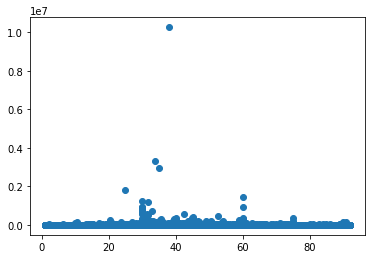

In [53]:
y = new_df['pledged']
x = new_df['duration']
plt.scatter(x,y)
plt.show()

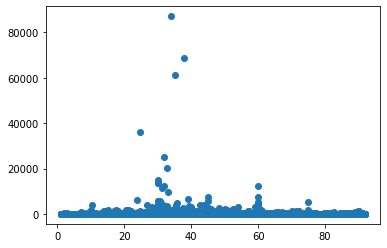

In [54]:
y = new_df['backers']
x = new_df['duration']
plt.scatter(x,y)
plt.show()

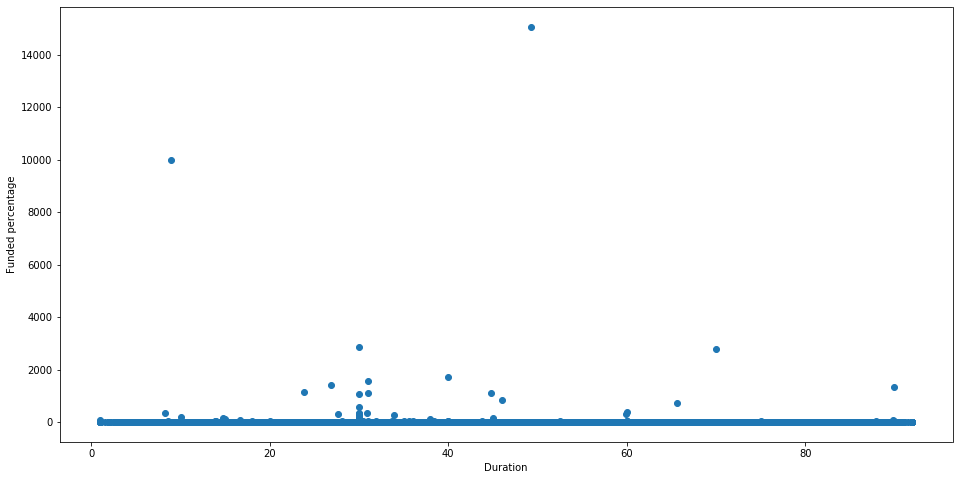

<Figure size 432x288 with 0 Axes>

In [55]:
y = new_df["funded percentage"]
x = new_df['duration']

fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(x, y)
ax.set_xlabel('Duration')
ax.set_ylabel('Funded percentage')
plt.show()
plt.savefig('duration_percfunded.jpg')

In [56]:
y = new_df[['duration',"status_dummy"]].groupby('status_dummy').mean()

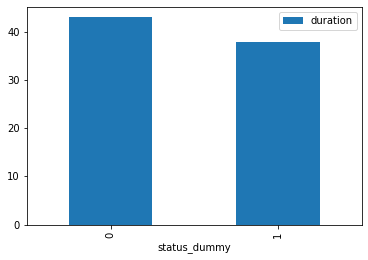

In [57]:
y.plot.bar()

## Check to see if project listing date is independent to month, day, year, and day of week
#### The Chi-Square test is a statistical hypothesis test to check independence of categorical variables. In this context, we use this test to see if projects are more or less likely to be posted in certain months, on certain days, or in particular years.

In [58]:
month_posted = new_df['project id'].groupby(new_df['month_posted_dummy']).count()
stats.chisquare(month_posted)

Power_divergenceResult(statistic=2776.5209005520896, pvalue=0.0)

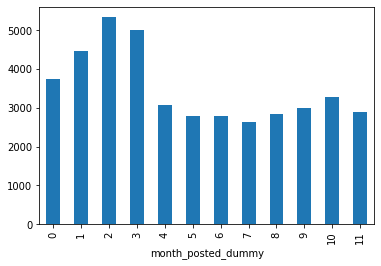

In [59]:
month_posted.plot.bar()

In [60]:
month_funded = new_df['project id'].groupby(new_df['month_funded_dummy']).count()
stats.chisquare(month_funded)

Power_divergenceResult(statistic=3348.6238617623862, pvalue=0.0)

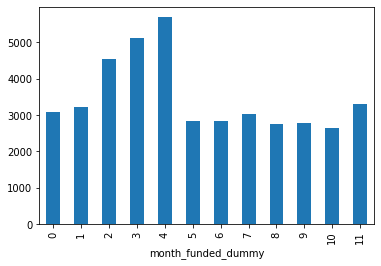

In [61]:
month_funded.plot.bar()

In [62]:
day_posted = new_df['project id'].groupby(new_df['day_posted']).count()
stats.chisquare(day_posted)

Power_divergenceResult(statistic=664.074950407495, pvalue=1.4887333283985904e-120)

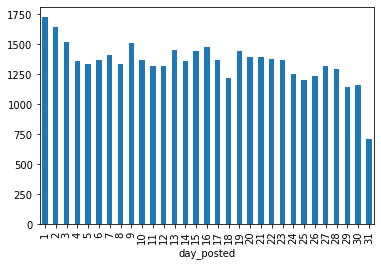

In [63]:
day_posted.plot.bar()

In [64]:
day_funded = new_df['project id'].groupby(new_df['day_funded']).count()
stats.chisquare(day_funded)

Power_divergenceResult(statistic=2642.9375492937547, pvalue=0.0)

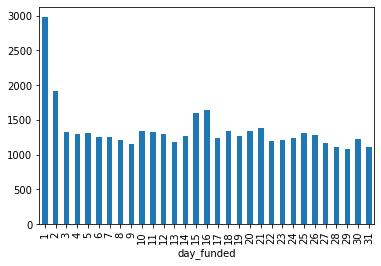

In [65]:
day_funded.plot.bar()

In [66]:
year_posted = new_df['project id'].groupby(new_df['year_posted']).count()
stats.chisquare(year_posted)

Power_divergenceResult(statistic=19780.878540187856, pvalue=0.0)

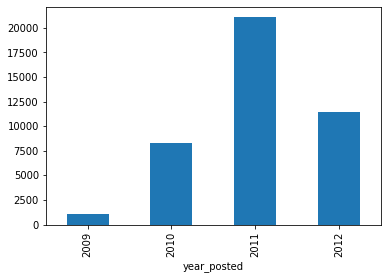

In [67]:
year_posted.plot.bar()

In [68]:
year_funded = new_df['project id'].groupby(new_df['year_funded']).count()
stats.chisquare(year_funded)

Power_divergenceResult(statistic=20089.310747831074, pvalue=0.0)

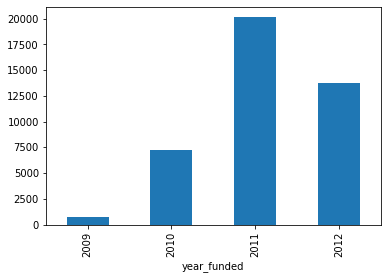

In [69]:
year_funded.plot.bar()

In [70]:
weekDay_posted = new_df['project id'].groupby(new_df['dayOfWeek_posted']).count()
stats.chisquare(weekDay_posted)

Power_divergenceResult(statistic=2879.8277765827775, pvalue=0.0)

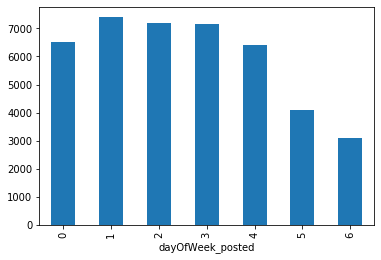

In [71]:
weekDay_posted.plot.bar()

In [72]:
weekDay_funded = new_df['project id'].groupby(new_df['dayOfWeek_funded']).count()
stats.chisquare(weekDay_funded)

Power_divergenceResult(statistic=295.2817571281757, pvalue=8.387785658465541e-61)

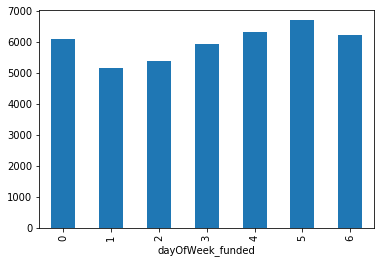

In [73]:
weekDay_funded.plot.bar()

## Check for joint significance of month, day of week, and year 
#### The F-test tests multiple hypothesis. The null hypothesis is that all slopes/coefficients are zero. Unfortunately the data isn't normally distributed so a parametric test probably isn't appropriate.
##### Month dummies: Jointly significant; Reject Null
##### Year dummies: Jointly significant; Reject Null
##### Day of week dummies: Not Jointly Significant; Do not reject the null

In [74]:
for each in ['posted', 'funded']:
    print(f'{each.capitalize()}:', stats.f_oneway(new_df['status_dummy'][new_df[f'month_{each}'] == 1], 
               new_df['status_dummy'][new_df[f'month_{each}'] == 2], 
               new_df['status_dummy'][new_df[f'month_{each}'] == 3],
              new_df['status_dummy'][new_df[f'month_{each}'] == 4],
              new_df['status_dummy'][new_df[f'month_{each}'] == 5],
              new_df['status_dummy'][new_df[f'month_{each}'] == 6],
              new_df['status_dummy'][new_df[f'month_{each}'] == 7],
              new_df['status_dummy'][new_df[f'month_{each}'] == 8],
              new_df['status_dummy'][new_df[f'month_{each}'] == 9],
              new_df['status_dummy'][new_df[f'month_{each}'] == 10],
              new_df['status_dummy'][new_df[f'month_{each}'] == 11],
              new_df['status_dummy'][new_df[f'month_{each}'] == 12]))

Posted: F_onewayResult(statistic=2.7794177318667224, pvalue=0.001290621161661944)
Funded: F_onewayResult(statistic=4.211975575580128, pvalue=2.8486971326095864e-06)


In [75]:
for each in ['posted', 'funded']:
    print(f'{each.capitalize()}:', stats.f_oneway(new_df['status_dummy'][new_df[f'year_{each}'] == 2009], 
               new_df['status_dummy'][new_df[f'year_{each}'] == 2010], 
               new_df['status_dummy'][new_df[f'year_{each}'] == 2011],
              new_df['status_dummy'][new_df[f'year_{each}'] == 2012]))

Posted: F_onewayResult(statistic=6.31445909442635, pvalue=0.0002814123156969091)
Funded: F_onewayResult(statistic=15.196937914090293, pvalue=7.012146438986875e-10)


In [76]:
for each in ['posted', 'funded']:
    print(f'{each.capitalize()}:', stats.f_oneway(new_df['status_dummy'][new_df[f'dayOfWeek_{each}'] == 0], 
               new_df['status_dummy'][new_df[f'dayOfWeek_{each}'] == 1], 
               new_df['status_dummy'][new_df[f'dayOfWeek_{each}'] == 2],
             new_df['status_dummy'][new_df[f'dayOfWeek_{each}'] == 3], 
              new_df['status_dummy'][new_df[f'dayOfWeek_{each}'] == 4],  
               new_df['status_dummy'][new_df[f'dayOfWeek_{each}'] == 5],
               new_df['status_dummy'][new_df[f'dayOfWeek_{each}'] == 6]))

Posted: F_onewayResult(statistic=7.054726074512105, pvalue=1.5977152142137403e-07)
Funded: F_onewayResult(statistic=1.4494149509388263, pvalue=0.1914102900357102)


## Kruskal-Wallis Test
#### Kruskal-Wallis test is a nonparametric version of the ANOVA test ; Interprets the MEDIAN difference

In [77]:
# compare samples
for each in ['posted', 'funded']:
 
    stat, p = kruskal(new_df['status_dummy'][new_df[f'month_{each}'] == 1], 
               new_df['status_dummy'][new_df[f'month_{each}'] == 2], 
               new_df['status_dummy'][new_df[f'month_{each}'] == 3],
              new_df['status_dummy'][new_df[f'month_{each}'] == 4],
              new_df['status_dummy'][new_df[f'month_{each}'] == 5],
              new_df['status_dummy'][new_df[f'month_{each}'] == 6],
              new_df['status_dummy'][new_df[f'month_{each}'] == 7],
              new_df['status_dummy'][new_df[f'month_{each}'] == 8],
              new_df['status_dummy'][new_df[f'month_{each}'] == 9],
              new_df['status_dummy'][new_df[f'month_{each}'] == 10],
              new_df['status_dummy'][new_df[f'month_{each}'] == 11],
              new_df['status_dummy'][new_df[f'month_{each}'] == 12])
    print(f'{each.capitalize()} Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret
    alpha = 0.01
    if p > alpha:
        print('Same distributions (fail to reject H0)')
    else:
        print('Different distributions (reject H0)')

Posted Statistics=30.559, p=0.001
Different distributions (reject H0)
Funded Statistics=46.293, p=0.000
Different distributions (reject H0)


In [78]:
# compare samples
for each in ['posted', 'funded']:
    stat, p = kruskal(new_df['status_dummy'][new_df[f'year_{each}'] == 2009], 
                    new_df['status_dummy'][new_df[f'year_{each}'] == 2010],
                    new_df['status_dummy'][new_df[f'year_{each}'] == 2011],
                    new_df['status_dummy'][new_df[f'year_{each}'] == 2012])
    print(f'{each.capitalize()} Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret
    alpha = 0.01
    if p > alpha:
        print('Same distributions (fail to reject H0)')
    else:
        print('Different distributions (reject H0)')

Posted Statistics=18.936, p=0.000
Different distributions (reject H0)
Funded Statistics=45.544, p=0.000
Different distributions (reject H0)


In [79]:
# compare samples
for each in ['posted', 'funded']:
    stat, p = kruskal(new_df['status_dummy'][new_df[f'dayOfWeek_{each}'] == 0], 
                   new_df['status_dummy'][new_df[f'dayOfWeek_{each}'] == 1], 
                   new_df['status_dummy'][new_df[f'dayOfWeek_{each}'] == 2],
                 new_df['status_dummy'][new_df[f'dayOfWeek_{each}'] == 3], 
                  new_df['status_dummy'][new_df[f'dayOfWeek_{each}'] == 4],  
                   new_df['status_dummy'][new_df[f'dayOfWeek_{each}'] == 5],
                   new_df['status_dummy'][new_df[f'dayOfWeek_{each}'] == 6])
    print(f'{each.capitalize()} Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret
    alpha = 0.01
    if p > alpha:
        print('Same distributions (fail to reject H0)')
    else:
        print('Different distributions (reject H0)')

Posted Statistics=42.292, p=0.000
Different distributions (reject H0)
Funded Statistics=8.696, p=0.191
Same distributions (fail to reject H0)


## Dunn's Test
#### Dunn's test pinpoints which means are significantly different than the others
#### This section conducts the Dunn's test between 'status_dummy' and 'month', 'year', 'day of week' and 'year_month.'


In [80]:
scikit_posthocs.posthoc_dunn(new_df, val_col='status_dummy', group_col='month_posted', p_adjust='bonferroni')

,1,2,3,4,5,6,7,8,9,10,11,12
1,1.000000,0.027101,0.680131,1.0,1.000000,1.000000,1.0,1.0,1.000000,0.158743,1.000000,1.000000
2,0.027101,1.000000,1.000000,1.0,0.063191,0.202866,1.0,1.0,0.544404,1.000000,0.667578,0.126044
3,0.680131,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.000000,1.000000
4,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.000000,1.000000
5,1.000000,0.063191,1.000000,1.0,1.000000,1.000000,1.0,1.0,1.000000,0.276478,1.000000,1.000000
6,1.000000,0.202866,1.000000,1.0,1.000000,1.000000,1.0,1.0,1.000000,0.672972,1.000000,1.000000
7,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.000000,1.000000
8,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.000000,1.000000
9,1.000000,0.544404,1.000000,1.0,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.000000,1.000000
10,0.158743,1.000000,1.000000,1.0,0.276478,0.672972,1.0,1.0,1.000000,1.000000,1.000000,0.467064


In [81]:
scikit_posthocs.posthoc_dunn(new_df, val_col='status_dummy', group_col='month_funded', p_adjust='bonferroni')

,1,2,3,4,5,6,7,8,9,10,11,12
1,1.000000,1.0,0.269449,0.083151,1.000000,1.000000,1.000000,1.0,1.0,1.0,0.228951,1.000000
2,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.000000,1.000000
3,0.269449,1.0,1.000000,1.000000,0.023152,0.838899,0.085376,1.0,1.0,1.0,1.000000,0.005146
4,0.083151,1.0,1.000000,1.000000,0.003695,0.311561,0.023809,1.0,1.0,1.0,1.000000,0.000948
5,1.000000,1.0,0.023152,0.003695,1.000000,1.000000,1.000000,1.0,1.0,1.0,0.034919,1.000000
6,1.000000,1.0,0.838899,0.311561,1.000000,1.000000,1.000000,1.0,1.0,1.0,0.627222,1.000000
7,1.000000,1.0,0.085376,0.023809,1.000000,1.000000,1.000000,1.0,1.0,1.0,0.080245,1.000000
8,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.000000,1.000000
9,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.000000,1.000000
10,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.000000,1.000000


In [82]:
# 2010 and 2011 are significantly different 
# 2011 and 2012 are significantly different
scikit_posthocs.posthoc_dunn(new_df, val_col='status_dummy', group_col='year_posted', p_adjust='bonferroni')

,2009,2010,2011,2012
2009,1.0,1.000000,1.000000,1.00000
2010,1.0,1.000000,0.007564,1.00000
2011,1.0,0.007564,1.000000,0.00093
2012,1.0,1.000000,0.000930,1.00000


In [83]:
scikit_posthocs.posthoc_dunn(new_df, val_col='status_dummy', group_col='year_funded', p_adjust='bonferroni')

,2009,2010,2011,2012
2009,1.000000,1.000000,4.511020e-01,1.000000e+00
2010,1.000000,1.000000,1.095175e-03,9.969441e-01
2011,0.451102,0.001095,1.000000e+00,6.314071e-10
2012,1.000000,0.996944,6.314071e-10,1.000000e+00


In [84]:
#Sunday, Monday, and Tuesday are the best days to post a new campaign
scikit_posthocs.posthoc_dunn(new_df, val_col='status_dummy', group_col='dayOfWeek_posted', p_adjust='bonferroni')

,0,1,2,3,4,5,6
0,1.000000,1.000000,1.000000,0.628016,0.067526,0.000672,0.002054
1,1.000000,1.000000,1.000000,0.340379,0.029403,0.000233,0.000875
2,1.000000,1.000000,1.000000,1.000000,0.149575,0.001643,0.004611
3,0.628016,0.340379,1.000000,1.000000,1.000000,0.410119,0.548987
4,0.067526,0.029403,0.149575,1.000000,1.000000,1.000000,1.000000
5,0.000672,0.000233,0.001643,0.410119,1.000000,1.000000,1.000000
6,0.002054,0.000875,0.004611,0.548987,1.000000,1.000000,1.000000


In [85]:
scikit_posthocs.posthoc_dunn(new_df, val_col='status_dummy', group_col='dayOfWeek_funded', p_adjust='bonferroni')

,0,1,2,3,4,5,6
0,1.000000,0.405313,1.0,1.000000,0.864544,1.0,1.0
1,0.405313,1.000000,1.0,0.872227,1.000000,1.0,1.0
2,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.0
3,1.000000,0.872227,1.0,1.000000,1.000000,1.0,1.0
4,0.864544,1.000000,1.0,1.000000,1.000000,1.0,1.0
5,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.0
6,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.0


In [86]:
scikit_posthocs.posthoc_dunn(new_df, val_col='status_dummy', group_col='year_month_posted', p_adjust='bonferroni')

,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,37
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000
5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000
6,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000
7,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,...,0.310324,0.154507,0.340654,1.000000,0.074703,1.000000,0.209604,1.00000,1.000000,1.000000
8,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000
9,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000


In [87]:
scikit_posthocs.posthoc_dunn(new_df, val_col='status_dummy', group_col='year_month_funded', p_adjust='bonferroni')

,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,37
0,1.0,1.000000,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000
1,1.0,1.000000,1.0,1.0,0.172898,1.0,1.0,1.0,1.0,0.757344,...,0.538297,0.105584,0.371606,0.373413,1.000000,1.000000,0.344977,0.725151,1.000000e+00,1.000000
2,1.0,1.000000,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000
3,1.0,1.000000,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000
4,1.0,0.172898,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,0.990802
5,1.0,1.000000,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000
6,1.0,1.000000,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000
7,1.0,1.000000,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000
8,1.0,1.000000,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000
9,1.0,0.757344,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000


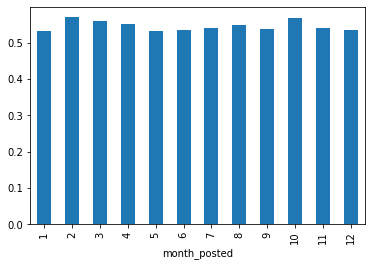

In [88]:
month_posted = new_df['status_dummy'].groupby(new_df['month_posted']).mean()
month_posted.plot.bar()

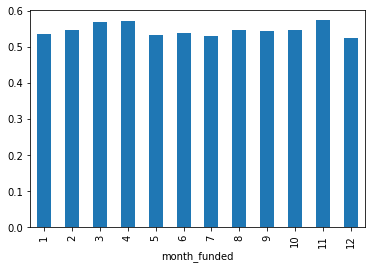

In [89]:
month_funded = new_df['status_dummy'].groupby(new_df['month_funded']).mean()
month_funded.plot.bar()

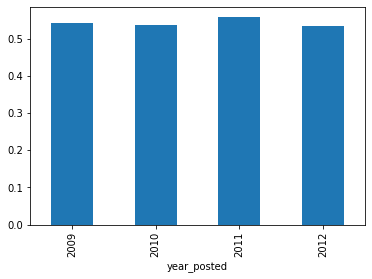

In [90]:
year_posted = new_df['status_dummy'].groupby(new_df['year_posted']).mean()
year_posted.plot.bar()

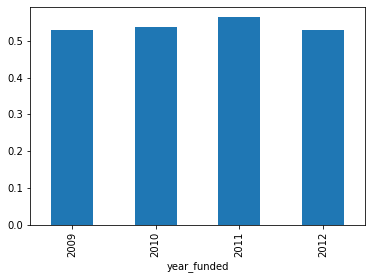

In [91]:
year_funded = new_df['status_dummy'].groupby(new_df['year_funded']).mean()
year_funded.plot.bar()

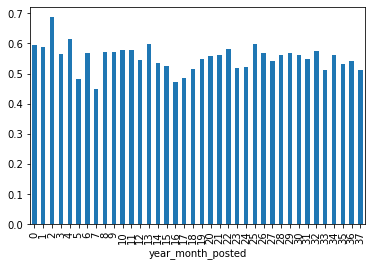

In [92]:
year_month_posted = new_df['status_dummy'].groupby(new_df['year_month_posted']).mean()
year_month_posted.plot.bar()

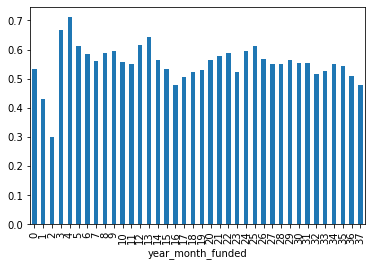

In [93]:
year_month_funded = new_df['status_dummy'].groupby(new_df['year_month_funded']).mean()
year_month_funded.plot.bar()

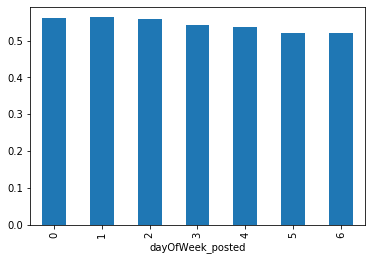

In [94]:
weekDayPosted = new_df['status_dummy'].groupby(new_df['dayOfWeek_posted']).mean()
weekDayPosted.plot.bar()

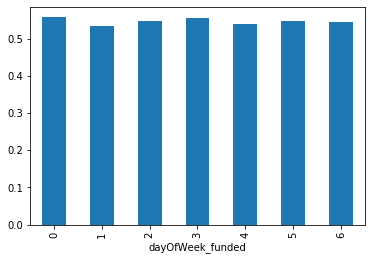

In [95]:
weekDayFunded = new_df['status_dummy'].groupby(new_df['dayOfWeek_funded']).mean()
weekDayFunded.plot.bar()

## Conduct Logistic Regression

In [96]:
new_df.columns

Index(['project id', 'name', 'url', 'category', 'subcategory', 'location',
       'status', 'goal', 'pledged', 'funded percentage', 'backers',
       'funded date', 'levels', 'reward levels', 'updates', 'comments',
       'duration', 'duration_td', 'Posting_Date', 'year_funded',
       'month_funded', 'day_funded', 'time_funded', 'dayOfWeek_funded',
       'year_posted', 'month_posted', 'day_posted', 'time_posted',
       'dayOfWeek_posted', 'city', 'state', 'country', 'category_dummy',
       'subcategory_dummy', 'status_dummy', 'year_posted_dummy',
       'year_funded_dummy', 'month_posted_dummy', 'month_funded_dummy',
       'country_dummy', 'year_month_posted', 'year_month_funded'],
      dtype='object')

In [97]:
X = new_df[['year_funded_dummy', 'year_posted_dummy', 'month_funded_dummy', 'month_posted_dummy', 
            'year_month_funded', 'year_month_posted', 'category_dummy', 'country_dummy']]
y = new_df['status_dummy']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [98]:
clf = LogisticRegression(C=0.5, penalty="l1", random_state=0).fit(X_train, y_train)

C:\Users\rayde\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [99]:
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

0.5747928616953474
0.5707867316700125


In [100]:
clf.predict_proba(X_test)

array([[0.41809565, 0.58190435],
       [0.43257158, 0.56742842],
       [0.48086475, 0.51913525],
       ...,
       [0.55673434, 0.44326566],
       [0.45095886, 0.54904114],
       [0.52511737, 0.47488263]])

In [101]:
y_pred = clf.predict(X_test)
print(confusion_matrix(y_test, y_pred))

[[1379 3398]
 [1092 4592]]


## Gaussian Naive Bayes
### Gaussian Naive Bayes supports continuous valued features and models each as conforming to a Gaussian (normal) distribution.

In [102]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
print(gnb.score(X_train, y_train))
print(gnb.score(X_test, y_test))

0.5283620140216698
0.5221298155052099


## Random Forest

In [103]:
random = RandomForestClassifier(random_state=0)
random.fit(X_train, y_train)
print(random.score(X_train, y_train))
print(random.score(X_test, y_test))

C:\Users\rayde\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.654302103250478
0.595449765796769


## Extreme Gradient Booster

In [104]:
xgboost = XGBClassifier(learning_rate=.5)
eval_set = [(X_test, y_test)]
xgboost.fit(X_train, y_train, eval_metric='auc', eval_set=eval_set, early_stopping_rounds=50)
print(xgboost.score(X_train, y_train))
print(xgboost.score(X_test, y_test))

[0]	validation_0-auc:0.62224
[1]	validation_0-auc:0.62610
[2]	validation_0-auc:0.62744
[3]	validation_0-auc:0.62896
[4]	validation_0-auc:0.63310
[5]	validation_0-auc:0.63603
[6]	validation_0-auc:0.63773
[7]	validation_0-auc:0.63817
[8]	validation_0-auc:0.63825
[9]	validation_0-auc:0.63772


C:\Users\rayde\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10]	validation_0-auc:0.63963
[11]	validation_0-auc:0.63895
[12]	validation_0-auc:0.63847
[13]	validation_0-auc:0.63839
[14]	validation_0-auc:0.63862
[15]	validation_0-auc:0.63787
[16]	validation_0-auc:0.63709
[17]	validation_0-auc:0.63661
[18]	validation_0-auc:0.63675
[19]	validation_0-auc:0.63731
[20]	validation_0-auc:0.63715
[21]	validation_0-auc:0.63722
[22]	validation_0-auc:0.63746
[23]	validation_0-auc:0.63743
[24]	validation_0-auc:0.63705
[25]	validation_0-auc:0.63696
[26]	validation_0-auc:0.63689
[27]	validation_0-auc:0.63663
[28]	validation_0-auc:0.63672
[29]	validation_0-auc:0.63625
[30]	validation_0-auc:0.63574
[31]	validation_0-auc:0.63571
[32]	validation_0-auc:0.63514
[33]	validation_0-auc:0.63498
[34]	validation_0-auc:0.63469
[35]	validation_0-auc:0.63460
[36]	validation_0-auc:0.63447
[37]	validation_0-auc:0.63417
[38]	validation_0-auc:0.63403
[39]	validation_0-auc:0.63421
[40]	validation_0-auc:0.63415
[41]	validation_0-auc:0.63402
[42]	validation_0-auc:0.63403
[43]	valid

In [105]:
dtrain = xgb.DMatrix(X_train,y_train)
dtest = xgb.DMatrix(X_test,y_test)
eval_set = [(X_test, y_test)]
param = {'learning_rate':0.5,'max_depth': 8, 'eval_metric':'auc',
         'objective': 'binary:logistic'}
num_round = 300
cv = xgb.cv(param, dtrain, num_round)

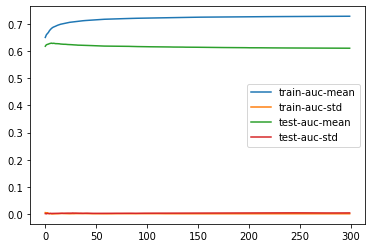

In [106]:
cv.plot()

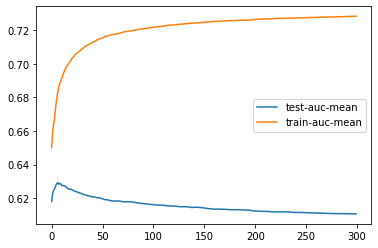

In [107]:
cv[['test-auc-mean','train-auc-mean' ]].plot()

## Exploratory Analysis

In [108]:
histogram = new_df['status_dummy'].groupby(new_df['status_dummy']).count()

In [109]:
y = list(histogram.values)

In [110]:
x = list(histogram.index)

(array([18939., 22902.]), array([0. , 0.5, 1. ]), <a list of 2 Patch objects>)

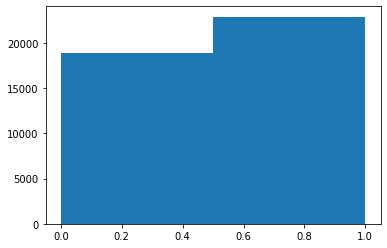

In [111]:
plt.hist(new_df['status_dummy'].T, bins=2)